# Python On Resonance (PyOR)

Author: Vineeth Thalakottoor \
Email: vineethfrancis.physics@gmail.com

## Tutorial 10: Correlation Spectroscopy (COSY)

In this tutorial we consider three H1 spins (Homonuclear). Spin 1 and 2; 1 and 3 are coupled. Spin 2 and 3 are not coupled.

Reference book - "NMR: The Toolkit, How Pulse Sequences Work" by P.J Hore, J.A. Jones and S. Wimperis

## Load Python packages and define path to the source file "PythonOnResonance.py"

In [1]:
pathSource = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_beta/Source'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append(pathSource)

import PythonOnResonance as PyOR

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib notebook
import sympy as sp
from sympy import *
from IPython.display import display, Math, Latex

## Generating Spin System

In [3]:
"""
Define Spin quantum numbers of your spins in "Slist1".
Slist1[0] is spin of first particle and Slist1[1] is spin of second particle.
""";

Slist1 = [1/2,1/2,1/2]

In [4]:
"""
Define Planck constant equals 1. 
Because NMR spectroscopists are more interested to write Energy in frequency units. 
if False then hbarEQ1 = hbar
""";

hbarEQ1 = True

In [5]:
"""
Generate Spin Operators
""";

System = PyOR.Numerical_MR(Slist1,hbarEQ1)

"""
Sx, Sy and Sz Operators
""";
Sx,Sy,Sz = System.SpinOperator()

"""
S+ and S- Operators
""";
Sp,Sm = System.PMoperators(Sx,Sy)

## Zeeman Hamiltonian in Lab Frame

In [6]:
"""
Gyromagnetic Ratio
Gamma = [Gyromagnetic Ratio spin 1, Gyromagnetic Ratio spin 1, ...]
""";
Gamma = [System.gammaH1,System.gammaH1,System.gammaH1]

"""
Define the field of the spectromter, B0 in Tesla.
"""
B0 = 9.4

"""
Define the chemical Shift of individual spins
Offset = [chemical Shift spin 1, chemical Shift spin 1, ..]
"""
Offset = [100,200,300] # Offset frequency in Hz

"""
Function "LarmorF" give the list Larmor frequencies of individual spins in lab frame
"""
LarmorF = System.LarmorFrequency(Gamma,B0,Offset)

Hz = System.Zeeman(LarmorF,Sz)

Larmor Frequency in MHz:  [-400.22811765 -400.22821765 -400.22831765]


## Initialize Density Matrix

In [7]:
"""
We will generate Initial Density Matrix in two ways: 
First we will generate a density matrix as we prefer say, Sz. 
Second we will create density matrix at thermal equlibrium

First Case
""";

Thermal_DensMatrix = False 

if Thermal_DensMatrix:
    Hz_EnUnit = System.Convert_FreqUnitsTOEnergy(Hz)
    HT_approx = False # High Temperature Approximation is False
    T = 300 # Temperature in Kelvin
    rho_in = System.EqulibriumDensityMatrix(Hz_EnUnit,T,HT_approx)
    rhoeq = rho_in.copy()   
else:
    rho_in = np.sum(Sz,axis=0) # Initial Density Matrix
    rhoeq = np.sum(Sz,axis=0)  # Equlibrium Density Matrix   
    print("Trace of density metrix = ", np.trace(rho_in))

Trace of density metrix =  0j


## Zeeman Halitonian in Rotating Frame

In [8]:
OmegaRF = [-System.gammaH1*B0,-System.gammaH1*B0,-System.gammaH1*B0]
Hz = System.Zeeman_RotFrame(LarmorF, Sz, OmegaRF)

## J Coupling Hamiltonian

In [9]:
'''
Define J couplings between individual spins
'''
Jlist = np.zeros((len(Slist1),len(Slist1)))
Jlist[0][1] = 10.5
Jlist[0][2] = 5.5
Jlist[1][2] = 0.0
Hj = System.Jcoupling_Weak(Jlist,Sz)

## Total Hamiltonian

In [10]:
Htotal = Hz + Hj

## Relaxation Constant

In [11]:
'''
Define longitudinal (R1) and transverse Relaxation (R2)
''';

R1 = 0
R2 = 0
System.Relaxation_Constants(R1,R2)

'''
Options for "Rprocess": "No Relaxation" 
                         or "Phenomenological" 
                         or "Auto-correlated Random Field Fluctuation"
                         or "Auto-correlated Dipolar Heteronuclear"
                         or "Auto-correlated Dipolar Homonuclear"
''';
Rprocess = "No Relaxation"

## COSY

In [12]:
dt = 0.00125 #50e-6
delay = dt
TD2 = 1000 # Direct Dimension
TD1 = 1000 # Indirect Dimension
method = "Unitary Propagator"

Window = True
LB = 5.0

# Phase cycling for first 90 deg pulse
Ph1 = [0.0,90.0]

def COSY(ph1):
    
    signal2D = np.zeros((TD1,TD2),dtype=complex)
            
    for i in range(TD1):
        
        # 90 deg Pulse
        rho = System.Rotate_H(rho_in,90,System.Pulse_Phase(Sx,Sy,ph1))
                
        # Evolution in indirect dimension
        Dpoints = int((i+1)*delay/dt)
        t, rho_t = System.Evolution_H(rhoeq,rho,Sx,Sy,Sz,Sp,Sm,Htotal,dt,Dpoints,method,Rprocess)
        
        # 90 deg Pulse
        rho1 = System.Rotate_H(rho_t[-1],90,np.sum(Sx,axis=0)) 
        
        # Evolution in direct dimension
        t1, rho_t1 = System.Evolution_H(rhoeq,rho1,Sx,Sy,Sz,Sp,Sm,Htotal,dt,TD2,method,Rprocess)
        
        # Detection
        det = np.sum(Sx,axis=0) + 1j *np.sum(Sy,axis=0)
        t1, Ex_det = System.Expectation_H(rho_t1,det,dt,TD2)
        
        # Windowing
        if Window:
            Ex_det = System.WindowFunction(t1,Ex_det,LB)
            
        signal2D[i,:] = Ex_det

    return t1, signal2D

start_time = time.time()

t1, signal2D_0 = COSY(Ph1[0])
t1, signal2D_90 = COSY(Ph1[1])

end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Total time = 29.911785364151 seconds 


## Fourier Spectrum

In [13]:
fs1 = 1.0/delay
fs2 = 1.0/dt

'''
Quadrature in direct and indirect dimension
''';

if True:    
    F1, F2, spectrum_0 = System.FourierTransform2D(signal2D_0,fs1,fs2,1)
    F1, F2, spectrum_90 = System.FourierTransform2D(signal2D_90,fs1,fs2,1)
    spectrum = spectrum_0 - 1j * spectrum_90
else:
    # States-Haberkorn-Ruben
    F2, spectrum_0 = System.FourierTransform2D_F2(signal2D_0,fs2,5)
    F2, spectrum_90 = System.FourierTransform2D_F2(signal2D_90,fs2,5)
    spectrum = spectrum_90.real + 1j * spectrum_0.real
    F1, spectrum = System.FourierTransform2D_F1(spectrum,fs1,1)

In [14]:
spectrum_0.shape

(1000, 1000)

<IPython.core.display.Javascript object>


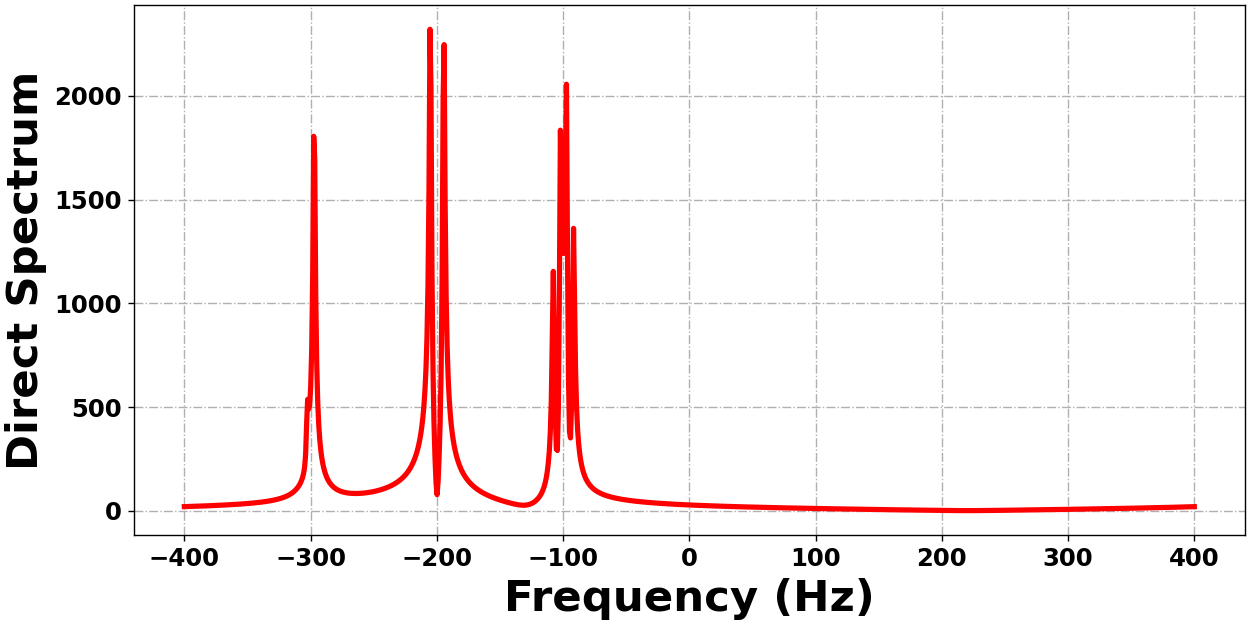

No handles with labels found to put in legend.


In [15]:
# 1D Spectra Direct Dimension

Spec_No = 500 # Spectra Number
absolute = True
if absolute:
    spectrum_PH0 = np.absolute(spectrum[Spec_No,:])
else:
    PH0 = 180.0
    spectrum_PH0 = System.PhaseAdjust_PH0(spectrum[Spec_No,:],PH0)

System.Plotting(1,F2,spectrum_PH0,"Frequency (Hz)","Direct Spectrum","red")

<IPython.core.display.Javascript object>


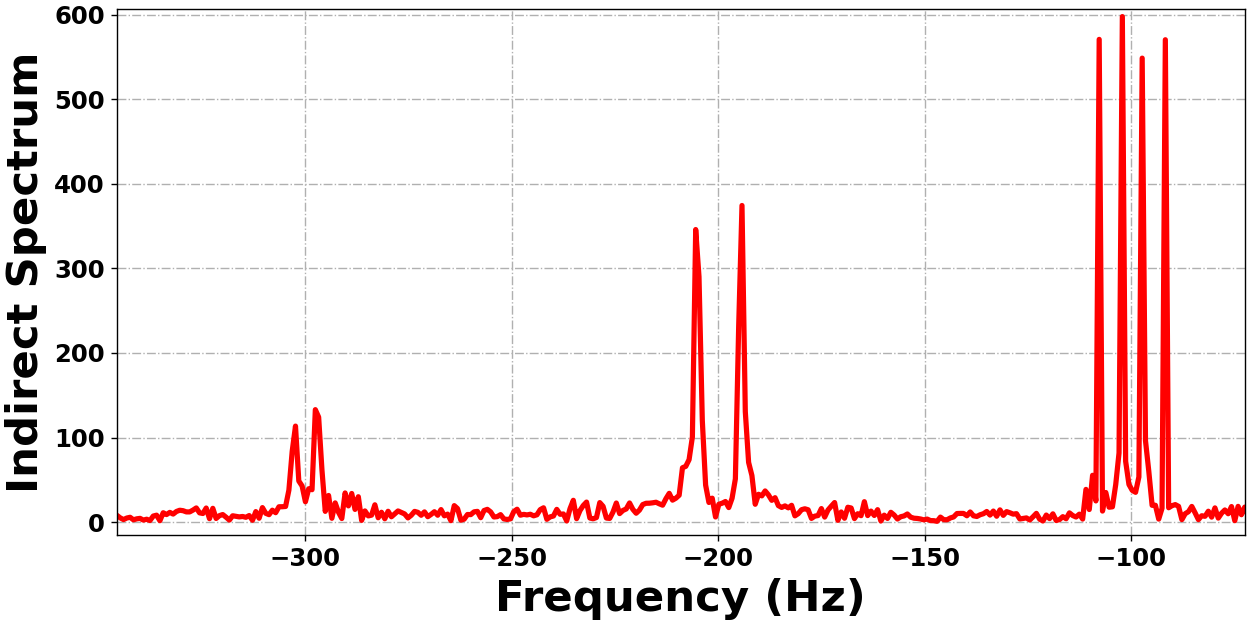

No handles with labels found to put in legend.


In [16]:
# 1D Spectra indirect Dimension
Spec_No = 500 # Spectra Number
absolute = True
if absolute:
    spectrum_PH0 = np.absolute(spectrum[:,Spec_No])
else:
    PH0 = 45.0
    spectrum_PH0 = System.PhaseAdjust_PH0(spectrum[:,Spec_No],PH0)
System.Plotting(2,F1,spectrum_PH0,"Frequency (Hz)","Indirect Spectrum","red")

## Ploting

<IPython.core.display.Javascript object>


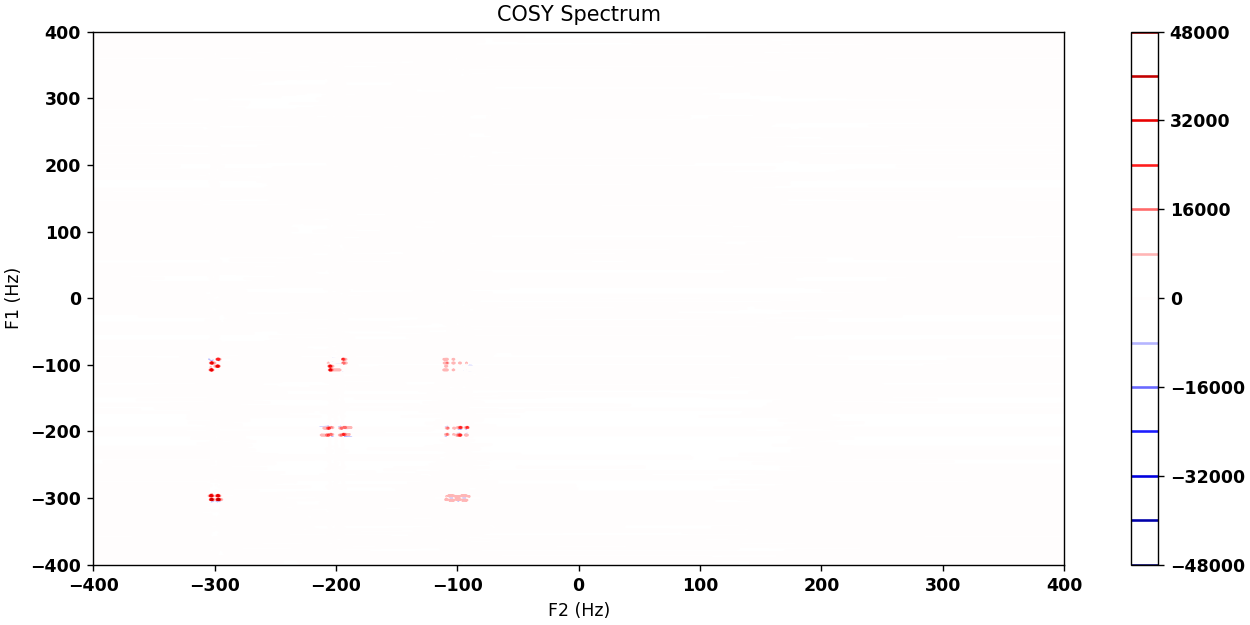

/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


In [17]:
# 2D Spectra
PH0 = 45
spectrum_PH0_2D = System.PhaseAdjust_PH0(spectrum,PH0)
System.PlottingContour(3,F2,F1,spectrum_PH0_2D,"F2 (Hz)","F1 (Hz)","COSY Spectrum")

<IPython.core.display.Javascript object>


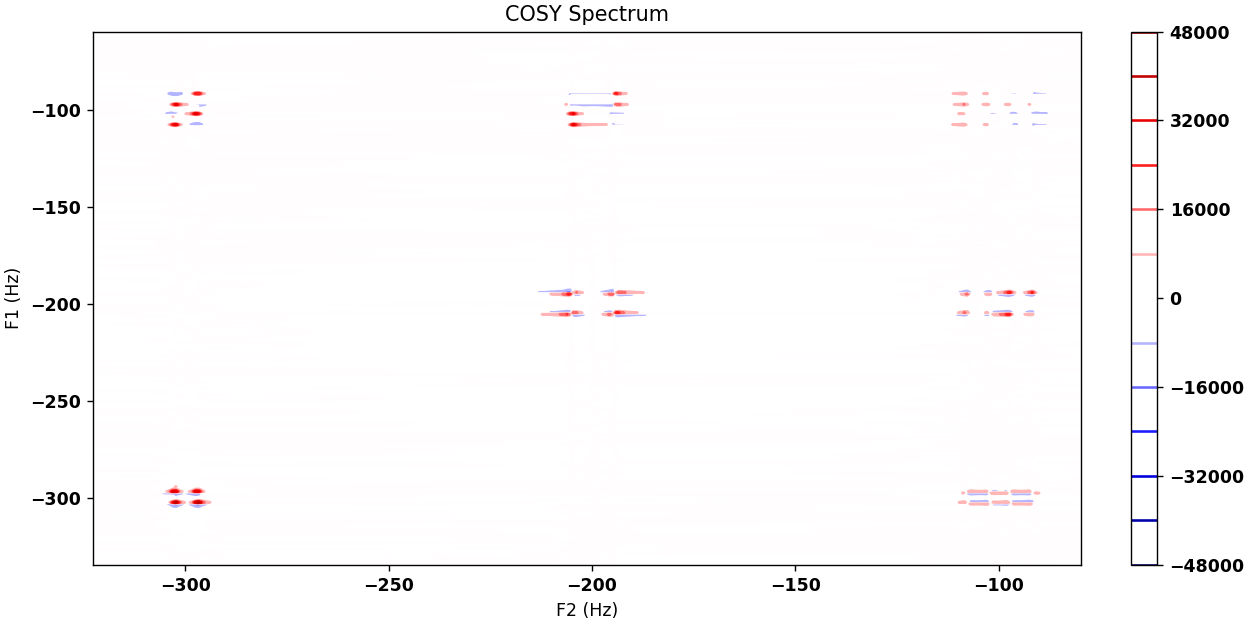

In [18]:
# Contour Plot
PH0 = 45
spectrum_PH0_2D = System.PhaseAdjust_PH0(spectrum,PH0)
System.PlottingContour(4,F2,F1,spectrum_PH0_2D,"F2 (Hz)","F1 (Hz)","COSY Spectrum")

<IPython.core.display.Javascript object>


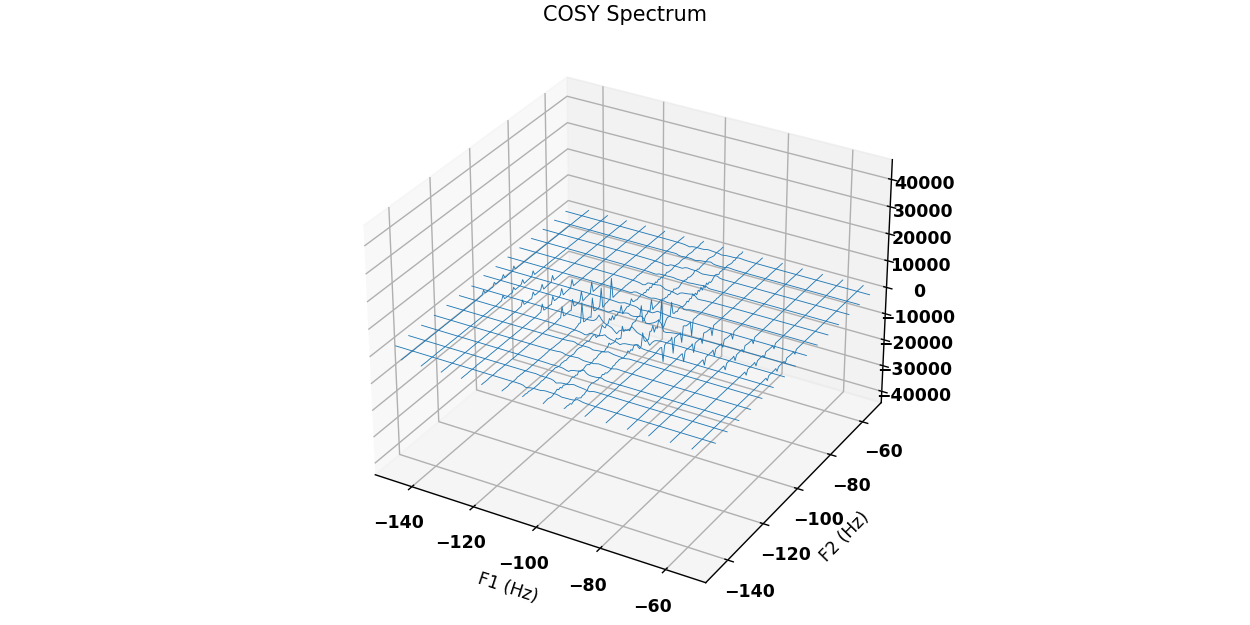

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [19]:
# Wire Plot
PH0 = 45
spectrum_PH0_2D = System.PhaseAdjust_PH0(spectrum,PH0)
System.Plotting3DWire(6,F2,F1,spectrum_PH0_2D,"F1 (Hz)","F2 (Hz)","COSY Spectrum",-50,-150)

## Any suggestion? write to me
If you see something is wrong please write to me, so that the PyOR can be error free.

vineethfrancis.physics@gmail.com